<a href="https://colab.research.google.com/github/RufusRubin/YOLO_V1/blob/main/INCEPTION_V3_YOLO_V1(large_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pretrainedmodels
!pip install torchsummary
!pip install imutils
!pip install tqdm

! pip install torchview
! pip install graphviz


In [ ]:
import os
from collections import Counter
from tqdm import tqdm
import sys
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models
import pretrainedmodels


from torchview import draw_graph
import graphviz


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from xml.etree import ElementTree as et

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class PotholeDataset(torch.utils.data.Dataset):

    def __init__(self, dir_path, S=7, B=2, C=1, transform=None):

        self.dir_path = dir_path
        self.transform = transform
        self.S = S
        self.C = C
        self.B = B

        self.data= list(sorted(os.listdir(os.path.join(dir_path, "images"))))
        self.annotation= list(sorted(os.listdir(os.path.join(dir_path, "annotations"))))

    def __len__(self):
      return len(self.annotation)


    def __getitem__(self, idx):


        img_path = os.path.join(self.dir_path, "images", self.data[idx])
        ann_path = os.path.join(self.dir_path, "annotations", self.annotation[idx])
        immg_path= os.path.join(self.dir_path, "images")

        #image = Image.open(img_path)


        image = cv2.imread(img_path)
        # convert BGR to RGB color format
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image_resized = cv2.resize(image, (self.width, self.height))
        #image_resized /= 255.0


        labels = []
        boxes = []
        tree = et.parse(ann_path)
        root = tree.getroot()
        
        class_dictionary = {'pothole':0}
        class_dictionary_1 = {'Pothole':0}
        class_dictionary_2 = {'pothole_water':0}
        class_dictionary_3 = {'damage':0}
        class_dictionary_4 = {'crack':0}
        class_dictionary_5 = {'pothole_water_m':0}
                
    
        if(int(root.find('size').find('height').text) != 0):
            filename = root.find('filename').text
            img = Image.open(immg_path + '/' + filename)
            img_width, img_height = img.size
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                
                if(klass== 'pothole'):
                    
                      klass = class_dictionary[klass]
                      #print("True")
                elif(klass=='Pothole'):
                    
                      klass = class_dictionary_1[klass]
                      #print("false")
                    
                elif(klass=='pothole_water'):
                    
                      klass = class_dictionary_2[klass]
                      #print("false")
                    
                    
                elif(klass=='damage'):
                    
                      klass = class_dictionary_3[klass]
                      #print("false")
                    
                elif(klass=='crack'):
                    
                      klass = class_dictionary_4[klass]
                      #print("false")
                    
                else:
                    
                      klass = class_dictionary_5[klass]
                      #print("false")
                    
                    

                    
                    
                    
                    
                    
                    
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])
            
        elif(int(root.find('size').find('height').text) != 0):
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                #klass = class_dictionary[klass]   
                
                    
                if(klass== 'pothole'):
                    
                      klass = class_dictionary[klass]
                      #print("True")
                elif(klass=='Pothole'):
                    
                      klass = class_dictionary_1[klass]
                      #print("false")
                    
                elif(klass=='pothole_water'):
                    
                      klass = class_dictionary_2[klass]
                      #print("false")
                    
                    
                elif(klass=='damage'):
                    
                      klass = class_dictionary_3[klass]
                      #print("false")
                    
                elif(klass=='crack'):
                    
                      klass = class_dictionary_4[klass]
                      #print("false")
                    
                else:
                    
                      klass = class_dictionary_5[klass]
                      #print("false")
                    
                    
                    
            
                                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])




        boxes = torch.Tensor(boxes)

        if self.transform:
          image, boxes = self.transform(image, boxes)


        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        for box in boxes:
          class_label, x, y, width, height = box
          class_label = int(class_label)
          i, j = int(self.S * y), int(self.S * x)
          x_cell, y_cell = self.S * x - j, self.S * y - i
          width_cell, height_cell = (
              width * self.S,
              height *self.S,
          )

          if label_matrix[i, j, 1] == 0:
            label_matrix[i, j, 1] = 1 
            box_coordinates = torch.Tensor(
                [x_cell, y_cell, width_cell, height_cell]
            )
            label_matrix[i,j, 2:6] = box_coordinates
            label_matrix[i,j, class_label] = 1

          return image, label_matrix

In [ ]:
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train')

In [ ]:
x,y =dataset[0]

In [ ]:
x.shape

(768, 1024, 3)

In [ ]:
y.shape

torch.Size([7, 7, 11])

# **Transform**

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

    
#orginal dataset
orginal_transform = Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
  
])


#for data augmentation

augmentated_transform = Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    #transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
  
])

In [ ]:
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train',transform= orginal_transform)

In [ ]:
x,y =dataset[0]

In [ ]:
x.shape

torch.Size([3, 299, 299])

In [ ]:
y.shape

torch.Size([7, 7, 11])

# **IOU**

In [ ]:
def intersection_over_union(boxes_pred, boxes_labels, box_format = "midpoint"):

  if box_format == "midpoint":
    box1_x1 = boxes_pred[..., 0:1] - boxes_pred[..., 2:3]/2
    box1_y1 = boxes_pred[..., 1:2] - boxes_pred[..., 3:4]/2
    box1_x2 = boxes_pred[..., 0:1] + boxes_pred[..., 2:3]/2
    box1_y2 = boxes_pred[..., 1:2] + boxes_pred[..., 3:4]/2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3]/2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4]/2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3]/2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4]/2

  elif box_format == "corners":
    box1_x1 = boxes_pred[..., 0:1]
    box1_y1 = boxes_pred[..., 1:2]
    box1_x2 = boxes_pred[..., 2:3]
    box1_y2 = boxes_pred[..., 3:4]
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.min(box1_x2, box2_x2)
  y2 = torch.min(box1_y2, box2_y2)

  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
#   print(intersection)

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

  union  = box1_area + box2_area -intersection

  return intersection/(union + 1e-6)

# **NMS**

In [ ]:
def non_max_suppression(bboxes,iou_threshold,prob_threshold,box_format = "corners"):
  
  assert type(bboxes) == list

  bboxes = [box for box in bboxes if box[1] > prob_threshold]
  bboxes = sorted(bboxes, key=lambda x : x[1], reverse = True)
  bboxes_aft_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0)

    bboxes = [
              box for box in bboxes
              if box[0] != chosen_box[0]
              or intersection_over_union(
                  torch.Tensor(chosen_box[2:]),
                  torch.Tensor(box[2:]),
                  box_format = box_format
              ) < iou_threshold
    ]

    bboxes_aft_nms.append(chosen_box)

  return bboxes_aft_nms

In [ ]:
def convert_cellboxes(predictions, S=7, C=1):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [ ]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

# **VISUALIZE THE IMAGE**

In [ ]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = 'Pothole'
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
      
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        conf = box[1]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle((upper_left_x * width, upper_left_y * height),box[2] * width,box[3] * height,linewidth=2,edgecolor=colors[int(class_pred)],facecolor="none")
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(upper_left_x,upper_left_y ,s=class_labels[int(class_pred)] + ': ' + str(conf),color="white",verticalalignment="top",bbox={"color": colors[int(class_pred)], "pad": 0})

    plt.show()

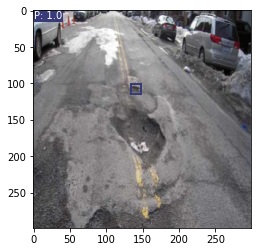

In [ ]:
S = [7]
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train', transform= orginal_transform)
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
for x, y in loader:
    boxes = []

    for i in range(y[0].shape[1]):

        boxes+= cellboxes_to_boxes(y)[0]
    boxes = non_max_suppression(boxes, iou_threshold=1, prob_threshold=0.7,  box_format="midpoint")
    plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
    #area_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
    break

# **YOLO LOSS**

In [ ]:
class yololoss(nn.Module):
  def __init__(self, S = 7, B = 2, C = 1):
    super(yololoss, self).__init__()
    self.mse = nn.MSELoss(reduction="sum")
    self.S = S
    self.B = B
    self.C = C
    self.lambda_coord = 5
    self.lambda_noobj = 0.5

  def forward(self, prediction, target):
    prediction = prediction.reshape(-1, self.S, self.S, self.C + self.B * 5)
#     print(prediction.shape)

    iou_b1 = intersection_over_union(prediction[...,2:6], target[...,2:6])
    iou_b2 = intersection_over_union(prediction[...,7:11], target[...,2:6])

    ious = torch.cat([iou_b1.unsqueeze(0),iou_b2.unsqueeze(0)], dim =0)
    iou_maxes, best_box = torch.max(ious, dim=0)
    exists_box = target[..., 1].unsqueeze(3) #Iobj_i
    
    if torch.sum(best_box) > 1:
        best_box = 1
    else:
        best_box = 0
    ####  BOX LOSS  ####
    #Box-Coordinates (mid-point, width & height)
    box_predictions = exists_box * (
        (
            best_box * prediction[...,7:11]
            + (1 - best_box) * prediction[...,2:6]
        )
    )

    box_targets = exists_box * target[...,2:6]

    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
        torch.abs(box_predictions[..., 2:4] + 1e-6)
    )
    
    #box dimensions: (N, S, S, 6)
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
    #(N, S, S, 4) -> (N*S*S, 4)
    box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2),
                        torch.flatten(box_targets, end_dim=-2),
                        )
    
    #### OBJECT LOSS ####
    pred_box = (
        best_box * prediction[..., 6:7] + (1 - best_box) * prediction[...,1:2]
    )
    # (N,S,S,1) -> (N*S*S*1)
    object_loss = self.mse(
        torch.flatten(exists_box * pred_box),
        torch.flatten(exists_box * target[...,1:2])
    )

    #### NO-OBJECT LOSS ####
    #(N, S, S, 1) -> (N, S*S*1)
    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * prediction[..., 1:2], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 1:2], start_dim=1),
    )

    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * prediction[..., 6:7], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 1:2], start_dim=1),
    )

    class_loss = self.mse(
        torch.flatten(exists_box * prediction[...,:1], end_dim = -2),
        torch.flatten(exists_box * target[...,:1], end_dim = -2)
    )

    loss = (
        self.lambda_coord * box_loss 
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss


# **MAP**

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold = 0.5, box_format="corners", num_classes=1):

  #pred_boxes_format = [[train_id, class_prob, box_prob, x1, y1, x2, y2], ...]
  average_precisions = []
    
  epsilon = 1e-6

  for c in range(num_classes):
    detections = []
    ground_truths = []

    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)

    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truths.append(true_box)

    amount_boxes = Counter([gt[0] for gt in ground_truths])
    
    for key, val in amount_boxes.items():
      amount_boxes[key] = torch.zeros(val)

    detections.sort(key = lambda x: x[2], reverse = True)
    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)

    for detection_idx, detection in enumerate(detections):
      ground_truth_img = [
              bbox for bbox in ground_truths  if bbox[0] == detection[0]
                   ]

      num_gts = len(ground_truth_img)
      best_iou = 0

      for idx, gt in enumerate(ground_truth_img):
        iou = intersection_over_union(
            torch.Tensor(detection[3:]),
            torch.Tensor(gt[3:]),
            box_format = box_format,
            )
        
        if iou > best_iou:
          best_iou = iou
          best_gt_idx = idx

      if best_iou > iou_threshold:

        if amount_boxes[detection[0]][best_gt_idx] == 0:
            TP[detection_idx] = 1
            amount_boxes[detection[0]][best_gt_idx] = 1
        else:
            FP[detection_idx] = 1
       
      else:
        FP[detection_idx] = 1 

    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))
    average_precisions.append(torch.trapz(precisions, recalls))

  return sum(average_precisions) / len(average_precisions), sum(average_precisions)




# **GET_BBOXES**

In [ ]:
def get_bboxes(loader,model,iou_threshold,threshold,pred_format="cells",box_format="midpoint",device=device):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                prob_threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

# **YOLO-V1 MODEL**

In [ ]:
class inceptionv3(nn.Module):
    def __init__(self, pretrained,split_size, num_boxes, num_classes):
        super(inceptionv3, self).__init__()
        
        S, B, C = split_size, num_boxes, num_classes
        
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['inceptionv3'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['inceptionv3'](pretrained = None)
        # change the classification layer
        #self.l0= nn.Linear(2048, lb)
        #self.dropout = nn.Dropout2d(0.4)

        self.avgpool= nn.AdaptiveAvgPool2d((7,7))
        self.flatten= nn.Flatten()
        self.linear_1= nn.Linear(2048 * S * S, 512)
        self.dropout= nn.Dropout(0.0)
        self.leakyrelu= nn.LeakyReLU(0.1)
        self.linear_2= nn.Linear(512, S * S *(C + B * 5))
        
        
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x=self.avgpool(x)
        x= self.flatten(x)
        x=self.linear_1(x)
        x=self.dropout(x)
        x=self.leakyrelu(x)
        x=self.linear_2(x)
        
        return x

In [ ]:
model = inceptionv3(pretrained=True,split_size = 7, num_boxes=2, num_classes = 1).to(device)
print(model)

inceptionv3(
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): Basic

In [ ]:
model = inceptionv3(pretrained=True,split_size = 7, num_boxes=2, num_classes = 1).to(device)
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
           Conv2d-10           [-1, 80, 73, 73]           5,120
      BatchNorm2d-11           [-1, 80, 73, 73]             160
      BasicConv2d-12           [-1, 80, 73, 73]               0
           Conv2d-13          [-1, 192, 71, 71]         138,240
      BatchNorm2d-14          [-1, 192,

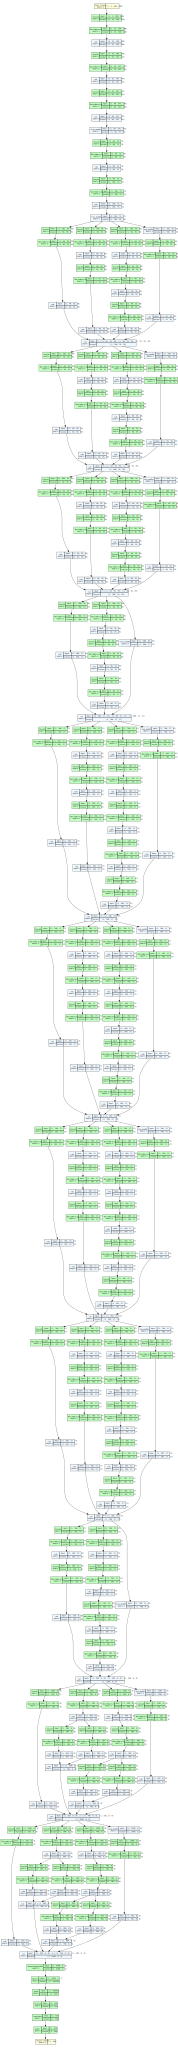

In [ ]:
model_plot = draw_graph(model, input_size=(1,3,299,299))
model_plot.visual_graph

In [ ]:
#def test(S = 7, B = 2, C = 1):
  #model = inceptionv3(pretrained=True,split_size = S, num_boxes=B, num_classes = C).to(device)
  #x = torch.randn((1, 3, 299, 299)).to(device)
  #print(model(x).shape)

#test()


# **OPTIMIZER AND LOSS**

In [ ]:
lr = 0.0001
BATCH_SIZE = 8
WEIGHT_DECAY = 0.00005
save_path = "inceptionv3_yolo_v1.pth"
fine_tune = True
load_path = "/kaggle/input/inception-yolo-v1-weight/inceptionv3_yolo_v1.pth"

In [ ]:
loss_fn = yololoss()

model = inceptionv3(pretrained=True,split_size = 7, num_boxes=2, num_classes = 1).to(device)

#optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=WEIGHT_DECAY)

optimizer= optim.SGD(model.parameters(), lr= lr, momentum= 0.9, weight_decay=WEIGHT_DECAY)


/opt/conda/lib/python3.7/site-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


# **WEIGHT LOADING**

In [ ]:
state_dict = torch.load(load_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

# **TRAINING FUNCTION**

In [ ]:
def train(model,dataloader):    
    # training function

    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):


        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()



    loss = running_loss/len(dataloader)

    print('Train Loss: %.3f'%(loss))

    return loss


# **VALIDATION FUNCTION**

In [ ]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        

        
        loss = running_loss/len(dataloader)

        print('Test Loss: %.3f '%(loss))
        
        return loss 

# **LOAD DATA**

In [ ]:
orginal_train_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train',transform = orginal_transform)

augmented_train_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train', transform = augmentated_transform)

train_data = torch.utils.data.ConcatDataset([orginal_train_dataset,augmented_train_dataset])

print(len(train_data))


orginal_test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/test', transform = orginal_transform)

augmented_test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/test',transform = augmentated_transform)

test_data = torch.utils.data.ConcatDataset([orginal_test_dataset,augmented_test_dataset])

print(len(test_data))




3194
504


# **DATA LOADER**

In [ ]:
train_loader = DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle=True,num_workers=4,drop_last = True)

test_loader = DataLoader(dataset = test_data,batch_size = BATCH_SIZE,shuffle=True, num_workers=4, drop_last = True)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
epochs= 50



train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

train_mAP,val_mAP=[],[]
train_precisions, val_precisions= [],[]
train_recalls, val_recalls= [],[]
train_average_precisions, val_average_precisions= [],[]


print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")


for epoch in range(epochs):
    
      print(f"Epoch {epoch+1} of {epochs}")

      # training

      train_epoch_loss = train(model, train_loader)
      train_loss.append(train_epoch_loss)

      #validation


      val_epoch_loss = validate(model, test_loader)
      val_loss.append(val_epoch_loss)


pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)
mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Train mAP: {mean_avg_prec}")
print(f"Train average_precisions: {average_precisions}")


pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)
mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Val mAP: {mean_avg_prec}")
print(f"Val average_precisions: {average_precisions}")



Training on 3194 examples, validating on 504 examples...
Epoch 1 of 50
Training


100%|██████████| 399/399 [01:17<00:00,  5.16it/s]

Train Loss: 0.196
Validating


Test Loss: 0.209 
Epoch 2 of 50
Training


100%|██████████| 399/399 [01:15<00:00,  5.31it/s]

Train Loss: 0.169
Validating


Test Loss: 0.343 
Epoch 3 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.33it/s]

Train Loss: 0.154
Validating


Test Loss: 0.392 
Epoch 4 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.35it/s]

Train Loss: 0.157
Validating


Test Loss: 0.439 
Epoch 5 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.34it/s]

Train Loss: 0.143
Validating


Test Loss: 0.446 
Epoch 6 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.33it/s]

Train Loss: 0.139
Validating


Test Loss: 0.450 
Epoch 7 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.36it/s]

Train Loss: 0.135
Validating


Test Loss: 0.544 
Epoch 8 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.34it/s]

Train Loss: 0.135
Validating


Test Loss: 0.470 
Epoch 9 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.38it/s]

Train Loss: 0.131
Validating


Test Loss: 0.522 
Epoch 10 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.39it/s]

Train Loss: 0.129
Validating


Test Loss: 0.546 
Epoch 11 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.44it/s]

Train Loss: 0.127
Validating


Test Loss: 0.599 
Epoch 12 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.122
Validating


Test Loss: 0.583 
Epoch 13 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.42it/s]

Train Loss: 0.121
Validating


Test Loss: 0.577 
Epoch 14 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.118
Validating


Test Loss: 0.629 
Epoch 15 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.122
Validating


Test Loss: 0.686 
Epoch 16 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.39it/s]

Train Loss: 0.119
Validating


Test Loss: 0.633 
Epoch 17 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.43it/s]

Train Loss: 0.112
Validating


Test Loss: 0.663 
Epoch 18 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.114
Validating


Test Loss: 0.668 
Epoch 19 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.114
Validating


Test Loss: 0.724 
Epoch 20 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.37it/s]

Train Loss: 0.117
Validating


Test Loss: 0.715 
Epoch 21 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.39it/s]

Train Loss: 0.112
Validating


Test Loss: 0.712 
Epoch 22 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.43it/s]

Train Loss: 0.110
Validating


Test Loss: 0.697 
Epoch 23 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.36it/s]

Train Loss: 0.111
Validating


Test Loss: 0.815 
Epoch 24 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.39it/s]

Train Loss: 0.104
Validating


Test Loss: 0.798 
Epoch 25 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.39it/s]

Train Loss: 0.109
Validating


Test Loss: 0.756 
Epoch 26 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.39it/s]

Train Loss: 0.107
Validating


Test Loss: 0.782 
Epoch 27 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.37it/s]

Train Loss: 0.105
Validating


Test Loss: 0.807 
Epoch 28 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.38it/s]

Train Loss: 0.105
Validating


Test Loss: 0.842 
Epoch 29 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.38it/s]

Train Loss: 0.104
Validating


Test Loss: 0.841 
Epoch 30 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.105
Validating


Test Loss: 0.879 
Epoch 31 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.45it/s]

Train Loss: 0.106
Validating


Test Loss: 0.845 
Epoch 32 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.105
Validating


Test Loss: 0.818 
Epoch 33 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.42it/s]

Train Loss: 0.101
Validating


Test Loss: 0.868 
Epoch 34 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.43it/s]

Train Loss: 0.100
Validating


Test Loss: 0.902 
Epoch 35 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.40it/s]

Train Loss: 0.102
Validating


Test Loss: 0.914 
Epoch 36 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.099
Validating


Test Loss: 0.996 
Epoch 37 of 50
Training


100%|██████████| 399/399 [01:14<00:00,  5.39it/s]

Train Loss: 0.097
Validating


Test Loss: 0.932 
Epoch 38 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.42it/s]

Train Loss: 0.099
Validating


Test Loss: 0.943 
Epoch 39 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.42it/s]

Train Loss: 0.098
Validating


Test Loss: 0.926 
Epoch 40 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.43it/s]

Train Loss: 0.097
Validating


Test Loss: 0.961 
Epoch 41 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.41it/s]

Train Loss: 0.097
Validating


Test Loss: 0.978 
Epoch 42 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.43it/s]

Train Loss: 0.096
Validating


Test Loss: 1.036 
Epoch 43 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.40it/s]

Train Loss: 0.101
Validating


Test Loss: 1.038 
Epoch 44 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.40it/s]

Train Loss: 0.097
Validating


Test Loss: 1.056 
Epoch 45 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.44it/s]

Train Loss: 0.095
Validating


Test Loss: 1.120 
Epoch 46 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.46it/s]

Train Loss: 0.097
Validating


Test Loss: 1.063 
Epoch 47 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.45it/s]

Train Loss: 0.093
Validating


Test Loss: 1.014 
Epoch 48 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.43it/s]

Train Loss: 0.095
Validating


Test Loss: 1.114 
Epoch 49 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.44it/s]

Train Loss: 0.094
Validating


Test Loss: 1.119 
Epoch 50 of 50
Training


100%|██████████| 399/399 [01:13<00:00,  5.46it/s]

Train Loss: 0.090
Validating


Test Loss: 1.162 
Train mAP: 0.974646270275116
Train average_precisions: 0.974646270275116
Val mAP: 0.6548248529434204
Val average_precisions: 0.6548248529434204


In [ ]:
torch.save(model.state_dict(), save_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model= inceptionv3(pretrained=True,split_size = 7, num_boxes=2, num_classes = 1).to(device)
state_dict = torch.load(f"/kaggle/working/{save_path}")
model.load_state_dict(state_dict)

test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/test', transform = orginal_transform)

test_loader = DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle=True,drop_last = True)

pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)


mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Test mAP: {mean_avg_prec}")
print(f"Test average_precisions: {average_precisions}")

Test mAP: 0.6856441497802734
Test average_precisions: 0.6856441497802734


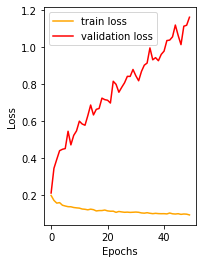

In [ ]:
"""
# mAP plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_mAP, color='green', label='train mAP')
plt.plot(val_mAP, color='blue', label='validataion mAP')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.legend()
# plt.savefig('../outputs/plots/accuracy.png')

"""
# loss plots
plt.subplot(122)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()

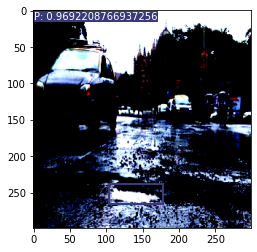

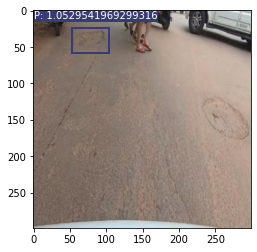

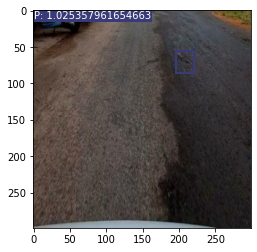

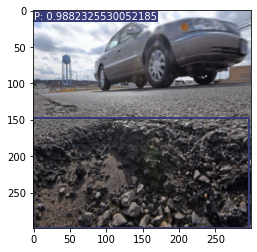

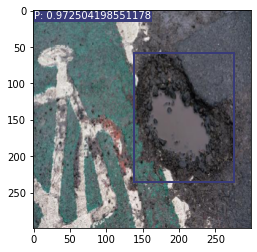

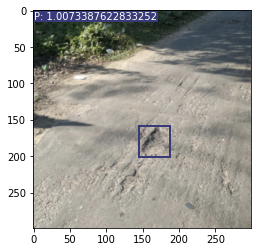

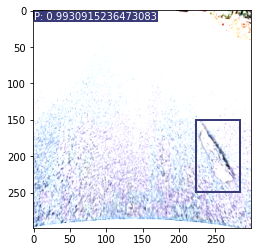

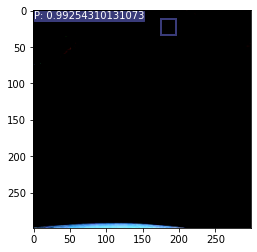

SystemExit: 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
for epoch in range(4):
    for x, y in train_loader:
       x = x.to(device)
       for idx in range(8):
           bboxes = cellboxes_to_boxes(model(x))
           bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, prob_threshold=0.4, box_format="corners")
           plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
           #area_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes)

       import sys
       sys.exit()

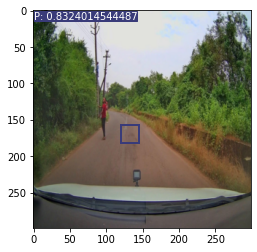

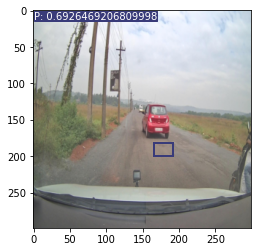

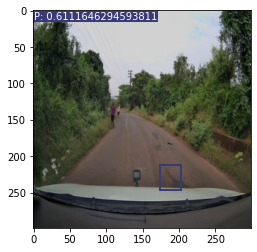

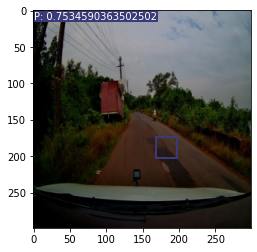

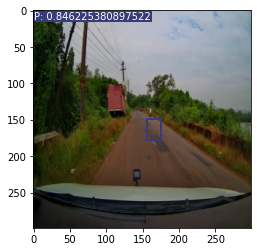

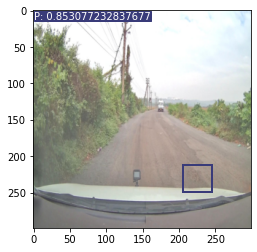

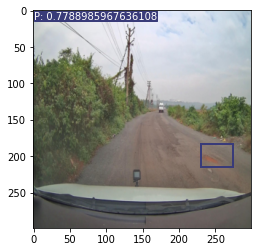

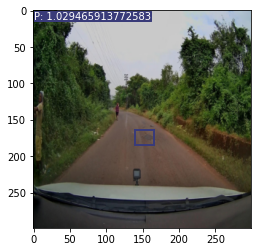

SystemExit: 

In [ ]:
for epoch in range(4):
    for x, y in test_loader:
       x = x.to(device)
       for idx in range(8):
           bboxes = cellboxes_to_boxes(model(x))
           bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, prob_threshold=0.4, box_format="corners")
           plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
           #area_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes)

       import sys
       sys.exit()

#### 